In [32]:
pip install imbalanced-learn seaborn

In [33]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline

In [34]:
df=pd.read_csv('asthma_disease_data.csv')
df1=df

In [28]:
continuous_columns = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']
categorical_columns = ['Gender', 'Smoking']
median_imputer = SimpleImputer(strategy='median')
df[continuous_columns] = median_imputer.fit_transform(df[continuous_columns])


mode_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = mode_imputer.fit_transform(df[categorical_columns])

scaler = MinMaxScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in continuous_columns:
    df = remove_outliers(df, col)
df2=df.drop(columns=['Diagnosis','DoctorInCharge'], axis=1)
corr_matrix = df2.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df_clean = df2.drop(columns=to_drop)

In [29]:
# print(X.columns)
# print(y.shape)
y = df1['Diagnosis']
X=df_clean
print(X.columns)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)
print(y_res.value_counts())


Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy',
       'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever',
       'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC',
       'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing',
       'NighttimeSymptoms', 'ExerciseInduced'],
      dtype='object')
(4536, 27)
(4536,)
Diagnosis
0    2268
1    2268
Name: count, dtype: int64


In [38]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

def scores(y_test, pred):
    print("Accuracy: ",accuracy_score(y_test, pred))
    print("Precision: ",precision_score(y_test, pred))
    print("Recall: ",recall_score(y_test, pred))
    print("F1 Score: ",f1_score(y_test, pred))
    print("ROC AUC Score: ",roc_auc_score(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}


k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

Random Forest Classifier
Accuracy:  0.9809104258443465
Precision:  0.9670658682634731
Recall:  0.9938461538461538
F1 Score:  0.9802731411229135
ROC AUC Score:  0.9814736387208297
[[345  11]
 [  2 323]]


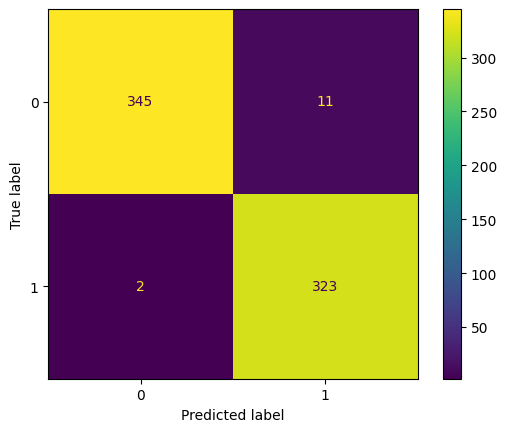

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)
rf=RandomForestClassifier(random_state=20)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
model = pipeline.fit(X_train, y_train)
print("Random Forest Classifier")
y_pred = model.predict(X_test)
scores(y_test, y_pred)

Decision Tree Classifier
Accuracy:  0.973568281938326
Precision:  0.9694189602446484
Recall:  0.9753846153846154
F1 Score:  0.9723926380368099
ROC AUC Score:  0.9736473638720831
[[346  10]
 [  8 317]]


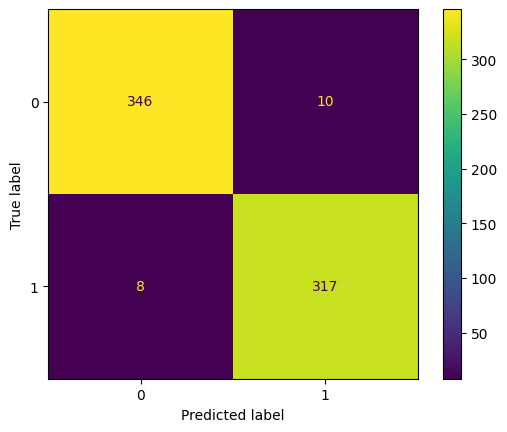

In [40]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=20)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', dt)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("Decision Tree Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Logistic Regression Classifier
Accuracy:  0.8781204111600588
Precision:  0.8689024390243902
Recall:  0.8769230769230769
F1 Score:  0.8728943338437979
ROC AUC Score:  0.8780682800345722
[[313  43]
 [ 40 285]]


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


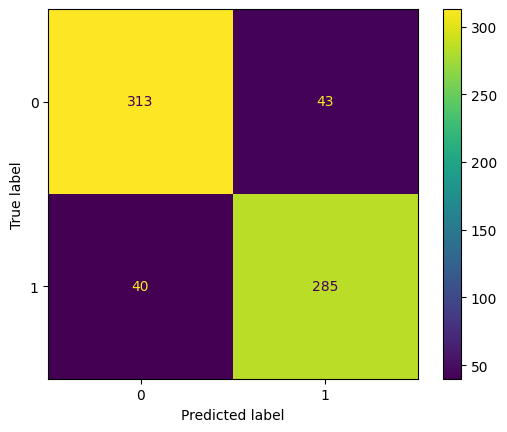

In [41]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgr)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("Logistic Regression Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)

SVM Classifier
Accuracy:  0.933920704845815
Precision:  0.8783783783783784
Recall:  1.0
F1 Score:  0.935251798561151
ROC AUC Score:  0.9367977528089887
[[311  45]
 [  0 325]]


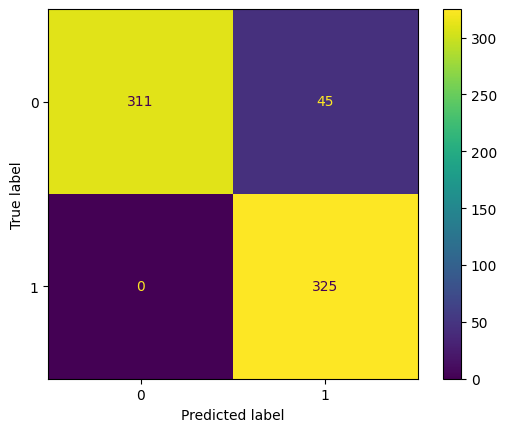

In [42]:
from sklearn.svm import SVC
sv = SVC()
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', sv)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("SVM Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)

## EDA

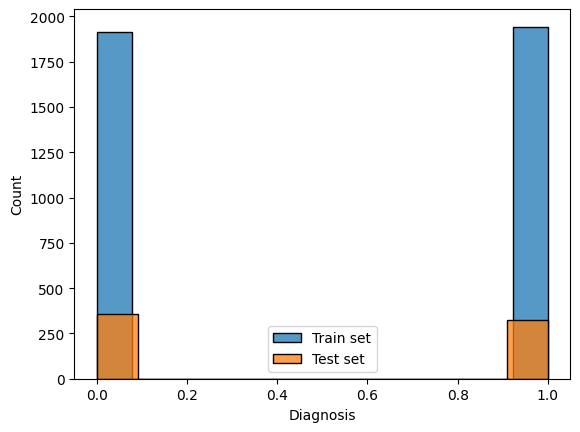

In [43]:
import seaborn as sns

sns.histplot(y_train, label="Train set")
sns.histplot(y_test, label="Test set")
plt.legend()

In [12]:
train_df = pd.concat([X_train, y_train], axis=1)

print(len(train_df.columns))
for col in train_df.columns:
    print(col)

28
PatientID
Age
Gender
Ethnicity
EducationLevel
BMI
Smoking
PhysicalActivity
DietQuality
SleepQuality
PollutionExposure
PollenExposure
DustExposure
PetAllergy
FamilyHistoryAsthma
HistoryOfAllergies
Eczema
HayFever
GastroesophagealReflux
LungFunctionFEV1
LungFunctionFVC
Wheezing
ShortnessOfBreath
ChestTightness
Coughing
NighttimeSymptoms
ExerciseInduced
Diagnosis


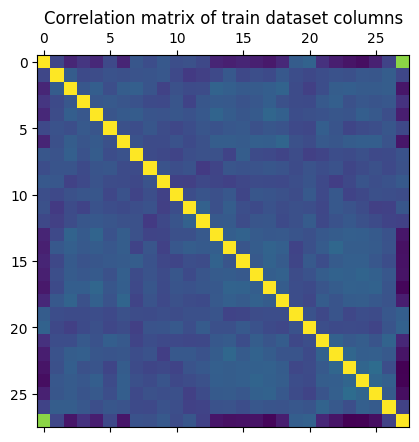

In [13]:
plt.matshow(train_df.corr())
plt.title('Correlation matrix of train dataset columns')
plt.show()

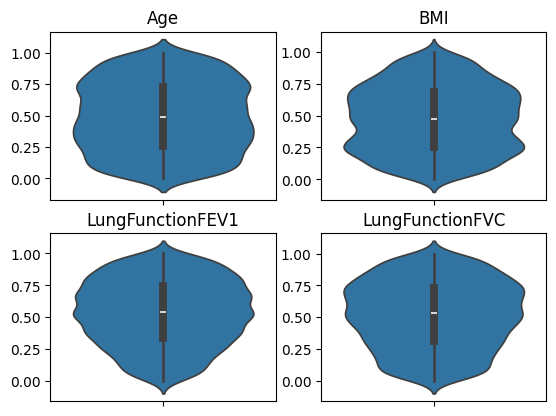

In [14]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.violinplot(train_df[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1

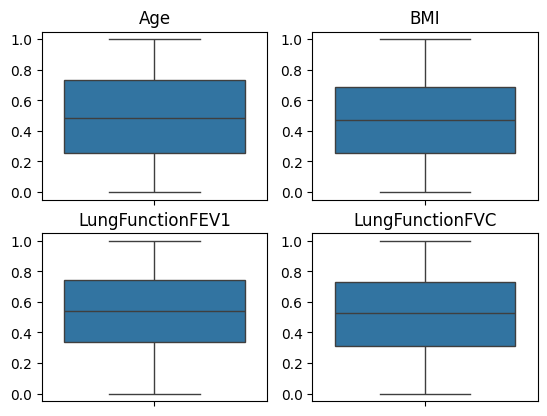

In [15]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.boxplot(train_df[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1


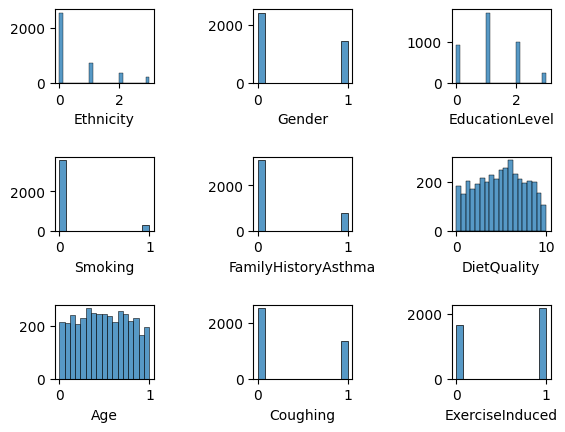

In [16]:
cols = ['Ethnicity', 'Gender', 'EducationLevel', 'Smoking', 'FamilyHistoryAsthma', 'DietQuality', 'Age', 'Coughing', 'ExerciseInduced']

fig, axes = plt.subplots(nrows=3, ncols=3)

fig.subplots_adjust(hspace=1, wspace=1)

counter = 0
for col in cols:
    sns.histplot(train_df[col], ax=axes[counter // 3, counter % 3])
    axes[counter // 3, counter % 3].set_ylabel("")
    counter += 1



## EDA on original dataset

<Axes: xlabel='Diagnosis', ylabel='Count'>

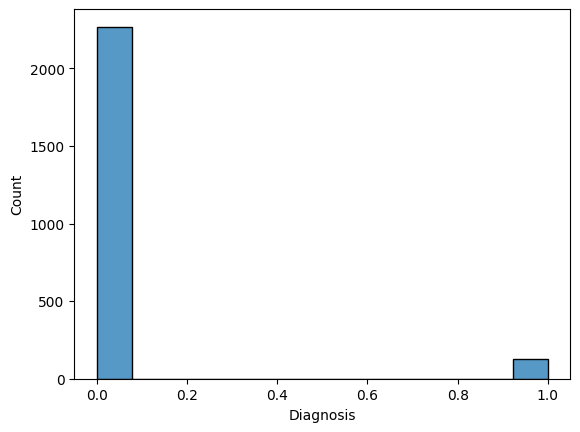

In [17]:
sns.histplot(df1['Diagnosis'])

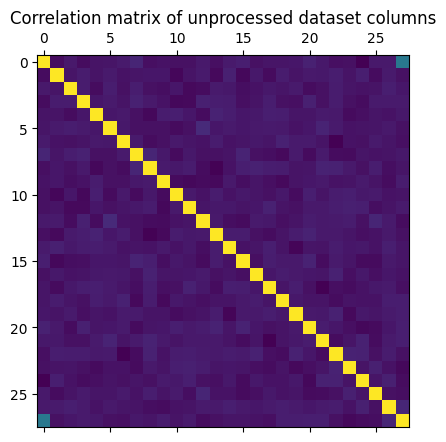

In [18]:
df1.drop('DoctorInCharge', axis=1, inplace=True)
plt.matshow(df1.corr())
plt.title('Correlation matrix of unprocessed dataset columns')
plt.show()


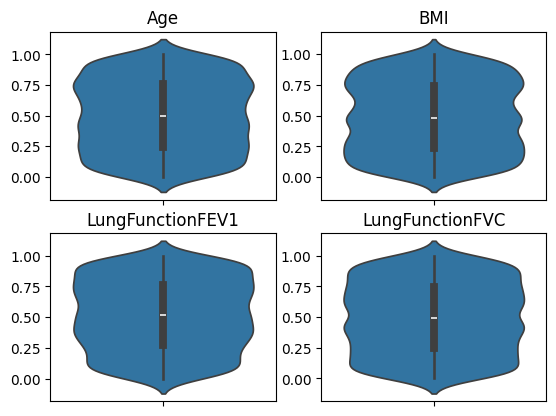

In [19]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.violinplot(df1[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1

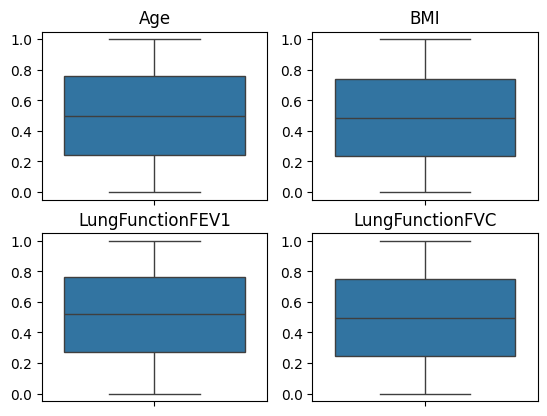

In [20]:
cols = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']

fig, axes = plt.subplots(nrows=2, ncols=2)

counter = 0
for col in cols:
    sns.boxplot(df1[col], ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_ylabel("")
    axes[counter // 2, counter % 2].set_title(col)
    counter += 1


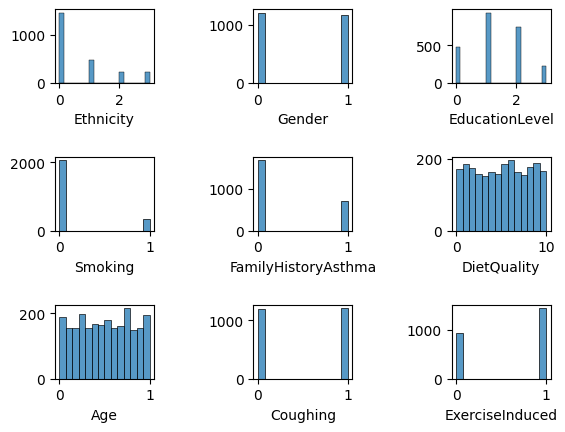

In [21]:
cols = ['Ethnicity', 'Gender', 'EducationLevel', 'Smoking', 'FamilyHistoryAsthma', 'DietQuality', 'Age', 'Coughing', 'ExerciseInduced']

fig, axes = plt.subplots(nrows=3, ncols=3)

fig.subplots_adjust(hspace=1, wspace=1)

counter = 0
for col in cols:
    sns.histplot(df1[col], ax=axes[counter // 3, counter % 3])
    axes[counter // 3, counter % 3].set_ylabel("")
    counter += 1



In [44]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"


Accuracy:  0.7151248164464024
Precision:  0.6625310173697271
Recall:  0.8215384615384616
F1 Score:  0.7335164835164835
ROC AUC Score:  0.7197579948141746
[[220 136]
 [ 58 267]]


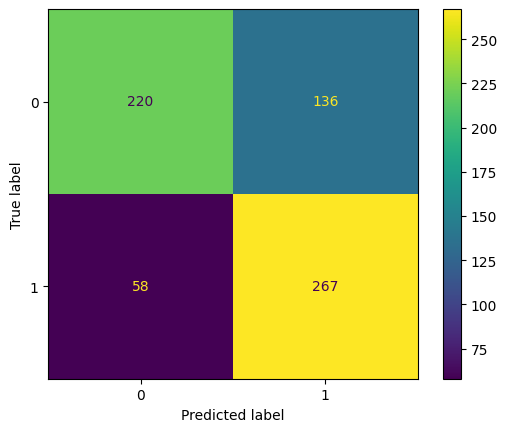

c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [45]:
import pydotplus
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

X_train_new=X_train.drop(columns=['PatientID'], axis=1)
feature_names=X_train_new.columns
X_test_new=X_test.drop(columns=['PatientID'], axis=1)
model_1=DecisionTreeClassifier(random_state=20,max_depth=4)
model_1.fit(X_train_new,y_train)
pred_1=model_1.predict(X_test_new)
scores(y_test, pred_1)
class_names = ['No Asthma', 'Asthma']
pydotplus.find_graphviz = lambda: {"dot": r"C:\Program Files\Graphviz\bin\dot.exe"}

dot_data = tree.export_graphviz(model_1, out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.replace('\n', ''))

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
for i in range(1):
    input_data = np.array(X_test_new.iloc[i])
    samples = input_data.reshape(1, -1)
    decision_paths = model_1.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))
    filename = f'tree_{i+1}.png'
    graph.write_png(filename)

Train set outliers:  1997
Train set inliers:  1858
Accuracy:  0.9676945668135095
Precision:  0.9690402476780186
Recall:  0.963076923076923
F1 Score:  0.9660493827160493
ROC AUC Score:  0.9674935177182368
[[346  10]
 [ 12 313]]


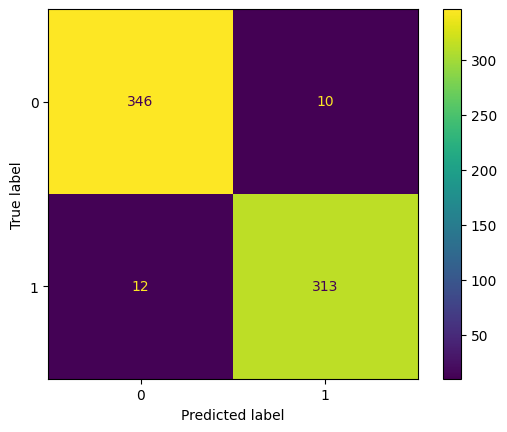

In [46]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=20)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
print("Train set outliers: ", len(y_pred_train[y_pred_train == -1]))
print("Train set inliers: ", len(y_pred_train[y_pred_train == 1]))

# print accuracy after removing outliers
X_train_clean = X_train[y_pred_train == -1]
y_train_clean = y_train[y_pred_train == -1]

model = RandomForestClassifier(random_state=20)
model.fit(X_train_clean, y_train_clean)
pred = model.predict(X_test)
scores(y_test, pred)

In [47]:
# perform grid-search with k-fold valdiation for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=20)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
model = grid_search.best_estimator_
pred = model.predict(X_test)
scores(y_test, pred)

KeyboardInterrupt: 

GMM Classifier
Accuracy:  0.2687224669603524
Precision:  0.1440329218106996
Recall:  0.1076923076923077
F1 Score:  0.12323943661971831
ROC AUC Score:  0.2617113223854797
[[148 208]
 [290  35]]


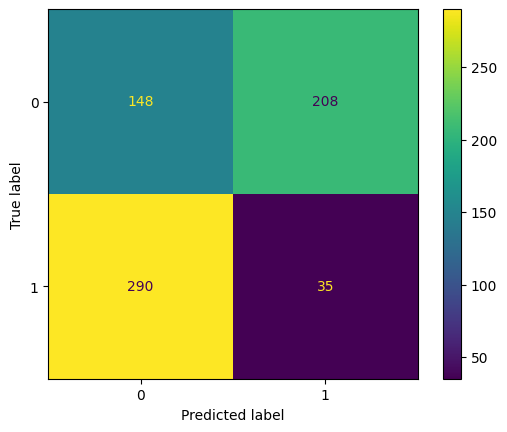

KMeans Classifier
Accuracy:  0.1894273127753304
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
ROC AUC Score:  0.1811797752808989
[[129 227]
 [325   0]]


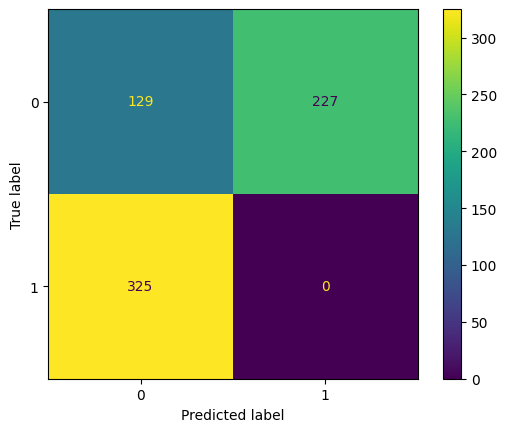

In [48]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# do train test split from x_res and y_res
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)

# apply gmm
gmm = GaussianMixture(n_components=2, random_state=42)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', gmm)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("GMM Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)

# apply kmeans
kmeans = KMeans(n_clusters=2, random_state=42)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', kmeans)
])
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
print("KMeans Classifier")
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores(y_test, y_pred)